<h2>Importing Libraries</h2>

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

<h4>Load the Dataset</h4>

In [61]:
np.random.seed(42)
tf.random.set_seed(42)

df = pd.read_csv("MicrosoftStock.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

In [62]:
df.shape

(1259, 8)

In [63]:
df.head()

,index,date,open,high,low,close,volume,Name
0,390198,2013-02-08,27.35,27.71,27.31,27.55,33318306,MSFT
1,390199,2013-02-11,27.65,27.92,27.50,27.86,32247549,MSFT
2,390200,2013-02-12,27.88,28.00,27.75,27.88,35990829,MSFT
3,390201,2013-02-13,27.93,28.11,27.88,28.03,41715530,MSFT
4,390202,2013-02-14,27.92,28.06,27.87,28.04,32663174,MSFT


<p>Instead of just focusing on closing price we take five feature</p>

In [64]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

features = ["open", "high", "low", "close", "volume"]
data = df[features].values  # shape (N, 5)

<h5>Scaling</h5>

In [65]:
# Separate scaler for features and target
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [66]:
# We'll predict 'close' price (index 3)
close_prices = df[["close"]].values
scaler_target.fit(close_prices)

MinMaxScaler()

<h3>Creating training Sample</h3>

In [67]:
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])  # All features for sequence
        y.append(data[i, 3])          # predict close price (index 3)
    return np.array(X), np.array(y)

In [68]:
# CHANGED: Kept lookback at 60 (good for stock data)
lookback = 60
X, y = create_sequences(scaled_data, lookback=lookback)

print(f"\nSequences created: {len(X)}")
print(f"Input shape: {X.shape}")
print(f"Output shape: {y.shape}")


Sequences created: 1199
Input shape: (1199, 60, 5)
Output shape: (1199,)


<h3>Spliting of Data in 70-15-15</h3>

In [69]:
train_size = int(0.70 * len(X))
val_size = int(0.85 * len(X))

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:val_size]
y_val = y[train_size:val_size]

X_test = X[val_size:]
y_test = y[val_size:]

In [70]:
print(f"\nData split:")
print(f"Training: {len(X_train)} samples")
print(f"Validation: {len(X_val)} samples")
print(f"Test: {len(X_test)} samples")


Data split:
Training: 839 samples
Validation: 180 samples
Test: 180 samples


<h3>Model building</h3> 

In [71]:
# 3. Build enhanced LSTM model
# CHANGED: Deeper architecture with Dropout, accepts 5 features
model = Sequential([
    # First LSTM layer
    LSTM(128, return_sequences=True, input_shape=(lookback, 5)),
    Dropout(0.2),
    
    # Second LSTM layer
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    
    # Third LSTM layer
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    
    # Dense layers
    Dense(25),
    Dense(1)
])

C:\Users\hp\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


<h4>Model Learning</h4>

In [72]:
# CHANGED: Using lower learning rate for stability
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

print("\n" + "="*80)
print("MODEL ARCHITECTURE")
print("="*80)
model.summary()


MODEL ARCHITECTURE


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                        │ (None, 60, 128)             │          68,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 60, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 25)                  │             825 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 131,283 (512.82 KB)

 Trainable params: 131,283 (512.82 KB)

 Non-trainable params: 0 (0.00 B)

<h3>Training the model</h3>

In [73]:
# CHANGED: Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

print("\n" + "="*80)
print("TRAINING")
print("="*80)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=70,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


TRAINING
Epoch 1/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - loss: 0.0066 - mae: 0.0588 - val_loss: 0.0011 - val_mae: 0.0278 - learning_rate: 0.0010
Epoch 2/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0015 - mae: 0.0297 - val_loss: 9.4890e-04 - val_mae: 0.0262 - learning_rate: 0.0010
Epoch 3/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0014 - mae: 0.0284 - val_loss: 3.8360e-04 - val_mae: 0.0149 - learning_rate: 0.0010
Epoch 4/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0013 - mae: 0.0265 - val_loss: 0.0015 - val_mae: 0.0347 - learning_rate: 0.0010
Epoch 5/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0011 - mae: 0.0249 - val_loss: 7.0119e-04 - val_mae: 0.0217 - learning_rate: 0.0010
Epoch 6/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0011 - mae: 0.0244 - val_loss: 0.0011 - val_mae: 0.0295 - learning_rate: 0.0010
Epoch 7/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0010 - mae: 0.0238 - val_loss: 0.0014 - val_mae: 0.0333 - learning_ra

<h3>Prediction</h3>

In [74]:
train_pred = model.predict(X_train, verbose=0)
val_pred = model.predict(X_val, verbose=0)
test_pred = model.predict(X_test, verbose=0)

# Inverse transform - create dummy arrays with proper shape
def inverse_transform_predictions(predictions, scaler, feature_index=3):
    """Inverse transform predictions back to original scale"""
    dummy = np.zeros((len(predictions), 5))
    dummy[:, feature_index] = predictions.flatten()
    inverse = scaler.inverse_transform(dummy)
    return inverse[:, feature_index].reshape(-1, 1)

train_pred_inv = inverse_transform_predictions(train_pred, scaler)
val_pred_inv = inverse_transform_predictions(val_pred, scaler)
test_pred_inv = inverse_transform_predictions(test_pred, scaler)

In [75]:
# Inverse transform actual values
y_train_inv = inverse_transform_predictions(y_train.reshape(-1, 1), scaler)
y_val_inv = inverse_transform_predictions(y_val.reshape(-1, 1), scaler)
y_test_inv = inverse_transform_predictions(y_test.reshape(-1, 1), scaler)

<h3>Enhanced Accuracy Metrics</h3>

In [76]:
def calculate_metrics(y_true, y_pred):
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    accuracy = 100 - mape
    return rmse, mae, mape, accuracy

train_rmse, train_mae, train_mape, train_acc = calculate_metrics(y_train_inv, train_pred_inv)
val_rmse, val_mae, val_mape, val_acc = calculate_metrics(y_val_inv, val_pred_inv)
test_rmse, test_mae, test_mape, test_acc = calculate_metrics(y_test_inv, test_pred_inv)

print("\n" + "="*80)
print("MODEL PERFORMANCE METRICS")
print("="*80)
print(f"\n{'Metric':<20} {'Train':<16} {'Validation':<16} {'Test':<16}")
print("-"*80)
print(f"{'RMSE':<20} ${train_rmse:<15.2f} ${val_rmse:<15.2f} ${test_rmse:<15.2f}")
print(f"{'MAE':<20} ${train_mae:<15.2f} ${val_mae:<15.2f} ${test_mae:<15.2f}")
print(f"{'MAPE (%)':<20} {train_mape:<15.2f} {val_mape:<15.2f} {test_mape:<15.2f}")
print(f"{'Accuracy (%)':<20} {train_acc:<15.2f} {val_acc:<15.2f} {test_acc:<15.2f}")
print("="*80)


MODEL PERFORMANCE METRICS

Metric               Train            Validation       Test            
--------------------------------------------------------------------------------
RMSE                 $1.46            $1.06            $2.14           
MAE                  $1.04            $0.80            $1.66           
MAPE (%)             2.36            1.28            2.05           
Accuracy (%)         97.64           98.72           97.95          



                    MODEL PERFORMANCE METRICS

Metric               Train            Validation       Test            
----------------------------------------------------------------------
RMSE                 $1.68            $1.70            $1.77           
MAE                  $1.22            $1.17            $1.27           
MAPE (%)             2.39            2.33            2.43           
Accuracy (%)         97.61           97.67           97.57          


<h3>Next day Prediction</h3>

In [78]:
last_sequence = scaled_data[-lookback:]
last_sequence = last_sequence.reshape(1, lookback, 5)

next_day_pred_scaled = model.predict(last_sequence, verbose=0)
next_day_pred = inverse_transform_predictions(next_day_pred_scaled, scaler)[0, 0]

current_price = df['close'].iloc[-1]

print("NEXT DAY PREDICTION")
print(f"Current Close Price: ${current_price:.2f}")
print(f"Predicted Next Day: ${next_day_pred:.2f}")
print(f"Expected Change: ${next_day_pred - current_price:.2f} ({((next_day_pred - current_price) / current_price * 100):.2f}%)")

NEXT DAY PREDICTION
Current Close Price: $89.61
Predicted Next Day: $90.59
Expected Change: $0.98 (1.09%)


In [80]:
# =========================
# 8. Save predictions
# =========================
test_start_idx = lookback + len(X_train) + len(X_val)
test_end_idx = test_start_idx + len(y_test)
test_dates = df['date'].iloc[test_start_idx:test_end_idx].reset_index(drop=True)

results = pd.DataFrame({
    "date": test_dates,
    "actual_close": y_test_inv.flatten(),
    "predicted_close": test_pred_inv.flatten(),
    "error": y_test_inv.flatten() - test_pred_inv.flatten(),
    "percent_error": ((y_test_inv.flatten() - test_pred_inv.flatten()) / y_test_inv.flatten()) * 100
})

results['date'] = pd.to_datetime(results['date']).dt.strftime('%Y-%m-%d')
results.to_csv("msft_lstm_results.csv", index=False)

<h3>Visualization</h3>

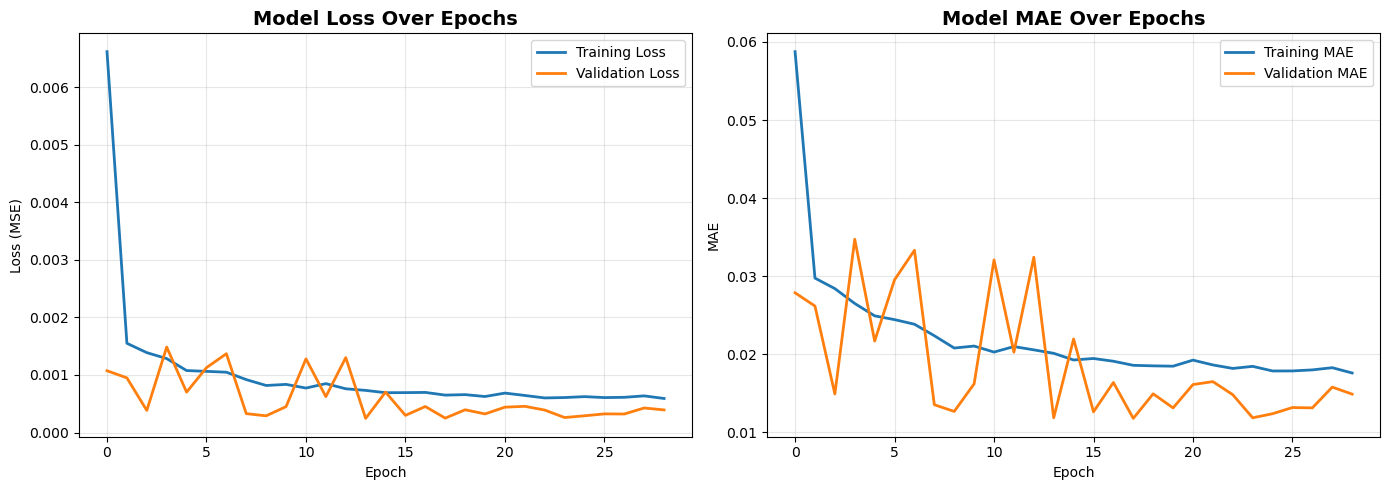

In [81]:
# Plot 1: Training History
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_title('Model MAE Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

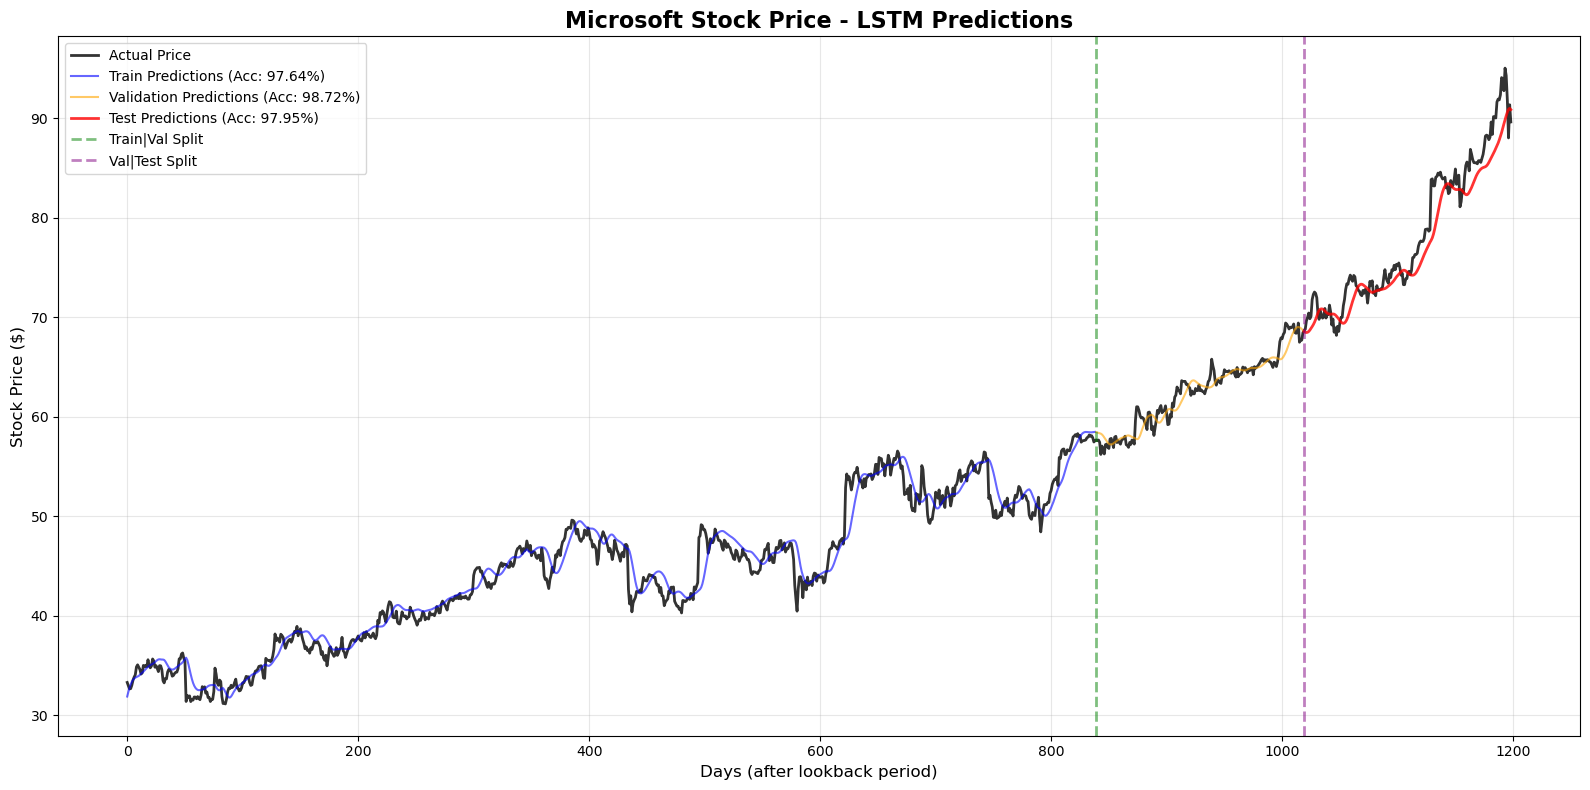

In [82]:
# Plot 2: Predictions vs Actual (IMPROVED)
fig, ax = plt.subplots(figsize=(16, 8))

# Get actual prices starting from lookback
actual_prices = df['close'].iloc[lookback:].values

# Create arrays for plotting
train_plot = np.full(len(actual_prices), np.nan)
val_plot = np.full(len(actual_prices), np.nan)
test_plot = np.full(len(actual_prices), np.nan)

# Fill in predictions
train_plot[:len(train_pred_inv)] = train_pred_inv.flatten()
val_plot[len(train_pred_inv):len(train_pred_inv)+len(val_pred_inv)] = val_pred_inv.flatten()
test_plot[len(train_pred_inv)+len(val_pred_inv):] = test_pred_inv.flatten()

# Plot
ax.plot(actual_prices, label='Actual Price', color='black', linewidth=2, alpha=0.8)
ax.plot(train_plot, label=f'Train Predictions (Acc: {train_acc:.2f}%)', 
        color='blue', linewidth=1.5, alpha=0.6)
ax.plot(val_plot, label=f'Validation Predictions (Acc: {val_acc:.2f}%)', 
        color='orange', linewidth=1.5, alpha=0.6)
ax.plot(test_plot, label=f'Test Predictions (Acc: {test_acc:.2f}%)', 
        color='red', linewidth=2, alpha=0.8)

# Mark splits
ax.axvline(x=len(train_pred_inv), color='green', linestyle='--', alpha=0.5, linewidth=2, label='Train|Val Split')
ax.axvline(x=len(train_pred_inv)+len(val_pred_inv), color='purple', linestyle='--', alpha=0.5, linewidth=2, label='Val|Test Split')

ax.set_title('Microsoft Stock Price - LSTM Predictions', fontsize=16, fontweight='bold')
ax.set_xlabel('Days (after lookback period)', fontsize=12)
ax.set_ylabel('Stock Price ($)', fontsize=12)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('full_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

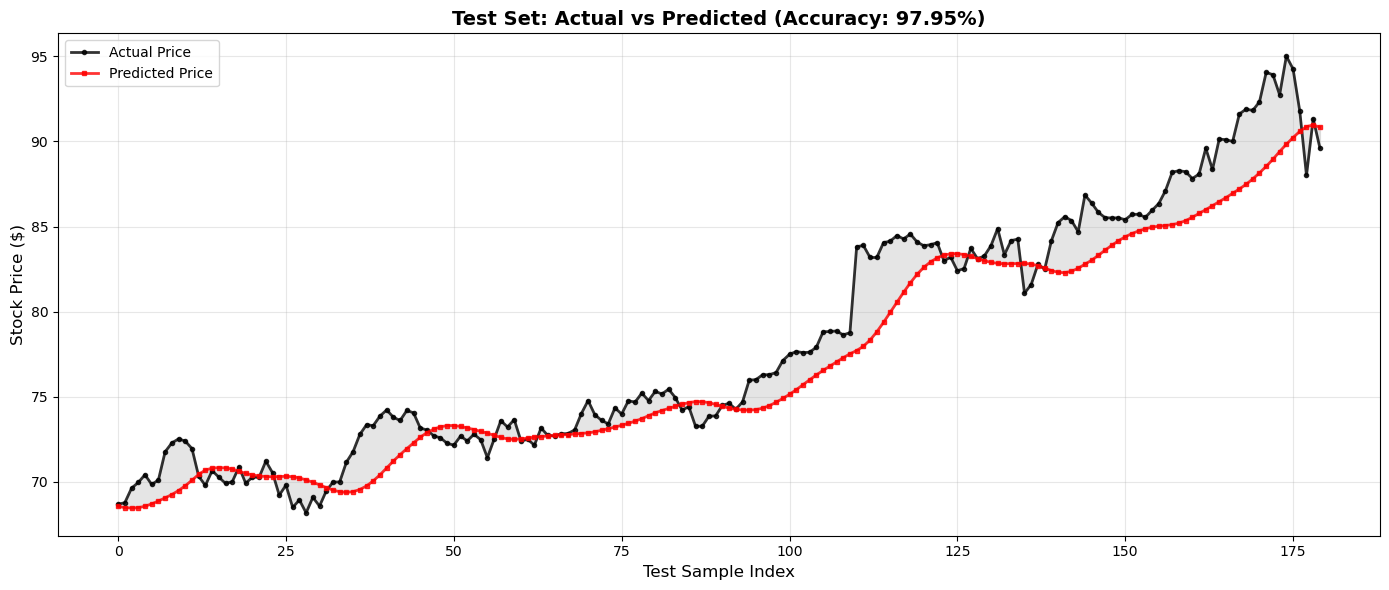

In [83]:
# Plot 3: Test Set Detail
fig, ax = plt.subplots(figsize=(14, 6))

test_indices = range(len(y_test_inv))
ax.plot(test_indices, y_test_inv, label='Actual Price', 
        color='black', linewidth=2, marker='o', markersize=3, alpha=0.8)
ax.plot(test_indices, test_pred_inv, label='Predicted Price', 
        color='red', linewidth=2, marker='s', markersize=3, alpha=0.8)
ax.fill_between(test_indices, y_test_inv.flatten(), test_pred_inv.flatten(), 
                alpha=0.2, color='gray')

ax.set_title(f'Test Set: Actual vs Predicted (Accuracy: {test_acc:.2f}%)', 
            fontsize=14, fontweight='bold')
ax.set_xlabel('Test Sample Index', fontsize=12)
ax.set_ylabel('Stock Price ($)', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('test_predictions_detail.png', dpi=300, bbox_inches='tight')
plt.show()

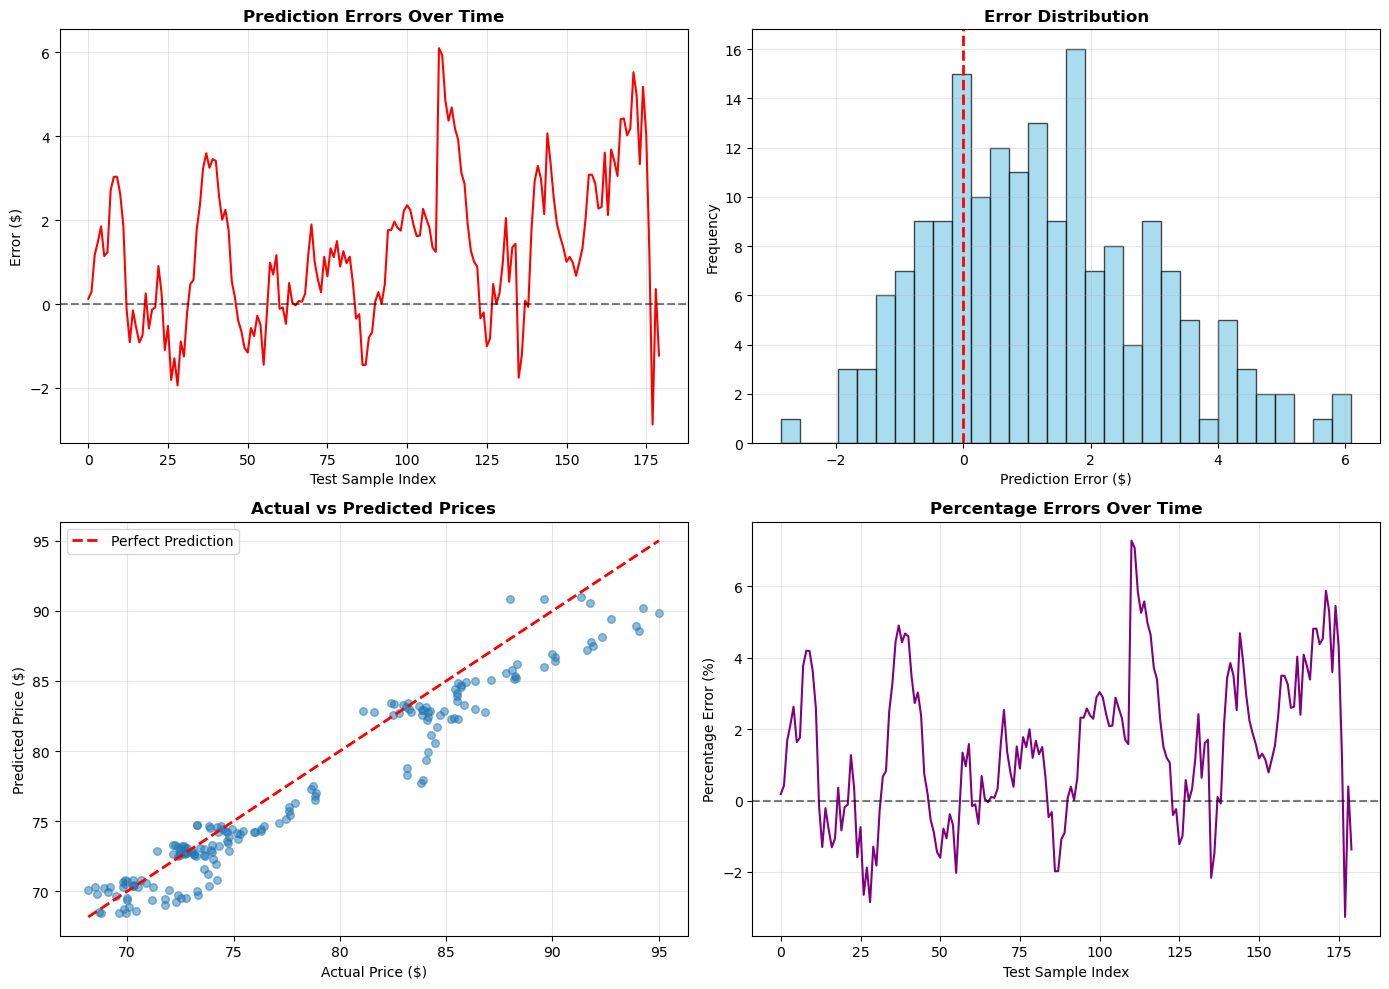

In [84]:
# Plot 4: Error Analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

errors = y_test_inv.flatten() - test_pred_inv.flatten()

# Error over time
axes[0, 0].plot(errors, color='red', linewidth=1.5)
axes[0, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0, 0].set_title('Prediction Errors Over Time', fontweight='bold')
axes[0, 0].set_xlabel('Test Sample Index')
axes[0, 0].set_ylabel('Error ($)')
axes[0, 0].grid(True, alpha=0.3)

# Error distribution
axes[0, 1].hist(errors, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_title('Error Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Prediction Error ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# Scatter: Actual vs Predicted
axes[1, 0].scatter(y_test_inv, test_pred_inv, alpha=0.5, s=30)
min_val = min(y_test_inv.min(), test_pred_inv.min())
max_val = max(y_test_inv.max(), test_pred_inv.max())
axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_title('Actual vs Predicted Prices', fontweight='bold')
axes[1, 0].set_xlabel('Actual Price ($)')
axes[1, 0].set_ylabel('Predicted Price ($)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Percentage errors
percent_errors = (errors / y_test_inv.flatten()) * 100
axes[1, 1].plot(percent_errors, color='purple', linewidth=1.5)
axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1, 1].set_title('Percentage Errors Over Time', fontweight='bold')
axes[1, 1].set_xlabel('Test Sample Index')
axes[1, 1].set_ylabel('Percentage Error (%)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()